Bias and Variance
================

[*Machine learning class*](https://sites.google.com/a/unal.edu.co/machine-learning-2013-2/) *support material, Universidad Nacional de Colombia, 2013*

The purpose of this notebook is to illustrate the bias-variance trade-off when learning regression models from data. We will use and example based on non-linear regression presented in Chapter 4 of [[Alpaydin10]](#biblio).

Training data generation
------------------------

First we will write a function to generate a random sample. The data generation model is the following:

$$r(x) = f(x) + \epsilon$$

with $\epsilon\sim\mathcal{N}(0,1)$

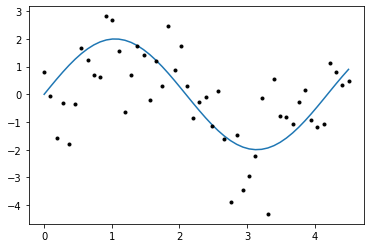

In [1]:
import numpy as np
import pylab as pl

def f(size):
    '''
    Returns a sample with 'size' instances without noise.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5)
    return (x,y)

def sample(size):
    '''
    Returns a sample with 'size' instances.
    '''
    x = np.linspace(0, 4.5, size)
    y = 2 * np.sin(x * 1.5) + pl.randn(x.size)
    return (x,y)
    
pl.clf()
f_x, f_y = f(50)
pl.plot(f_x, f_y)
x, y = sample(50)
pl.plot(x, y, 'k.')

Model fitting
=============

We will use least square regression (LSR) to fit a polynomial to the data. Actually, we will use multivariate linear regression, over a dataset built in the following way:

For each sample $x_{i}$ we build a vector $(1 , x_{i} , x_{i}^{2} , \dots , x_{i}^{n})$  and we use LSR to fit a function $g:\mathbb{R}^{n+1}\rightarrow\mathbb{R}$ to the training data.

In [4]:
# This illustrates how vander function works:
x1 = np.array([1,2,3])
print(np.vander(x1, 4))

[[ 1  1  1  1]
 [ 8  4  2  1]
 [27  9  3  1]]


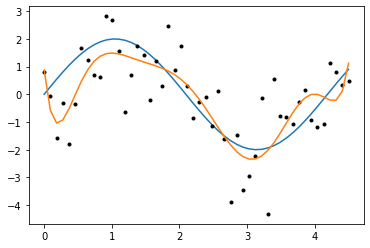

In [5]:
from sklearn.linear_model import LinearRegression

def fit_polynomial(x, y, degree):
    '''
    Fits a polynomial to the input sample.
    (x,y): input sample
    degree: polynomial degree
    '''
    model = LinearRegression()
    model.fit(np.vander(x, degree + 1), y)
    return model

def apply_polynomial(model, x):
    '''
    Evaluates a linear regression model in an input sample
    model: linear regression model
    x: input sample
    '''
    degree = model.coef_.size - 1
    y = model.predict(np.vander(x, degree + 1))
    return y

model = fit_polynomial(x, y, 8)
p_y = apply_polynomial(model, x)
pl.plot(f_x, f_y)
pl.plot(x, y, 'k.')
pl.plot(x, p_y)

Model averaging
---------------

The following code generates a set of samples of the same size and fits a poynomial to each sample. Then the average model is calculated. All the models, including the average model, are plotted.

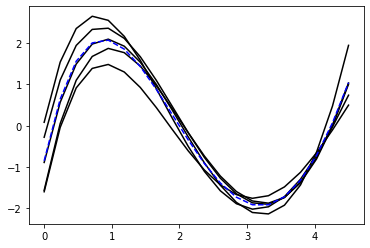

In [7]:
degree = 4
n_samples = 20
n_models = 5
avg_y = np.zeros(n_samples)
for i in range(n_models):
    (x,y) = sample(n_samples)
    model = fit_polynomial(x, y, degree)
    p_y = apply_polynomial(model, x)
    avg_y = avg_y + p_y
    pl.plot(x, p_y, 'k-')
avg_y = avg_y / n_models
pl.plot(x, avg_y, 'b--')

Calculating bias and variance
-----------------------------

Same as previous example, we generate several samples and fit a polynomial to each one. We calculate bias an variance among models for different polynomial degrees. Bias, variance and error are plotted against different degree values.

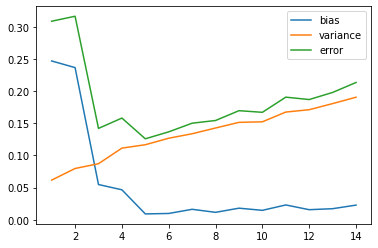

In [10]:
from numpy.linalg import norm
n_samples = 20
f_x, f_y = f(n_samples)
n_models = 100
max_degree = 15
var_vals =[]
bias_vals = []
error_vals = []
for degree in range(1, max_degree):
    avg_y = np.zeros(n_samples)
    models = []
    for i in range(n_models):
        (x,y) = sample(n_samples)
        model = fit_polynomial(x, y, degree)
        p_y = apply_polynomial(model, x)
        avg_y = avg_y + p_y
        models.append(p_y)
    avg_y = avg_y / n_models
    bias_2 = norm(avg_y - f_y)/f_y.size
    bias_vals.append(bias_2)
    variance = 0
    for p_y in models:
        variance += norm(avg_y - p_y)
    variance /= f_y.size * n_models
    var_vals.append(variance)
    error_vals.append(variance + bias_2)
pl.plot(range(1, max_degree), bias_vals, label='bias')
pl.plot(range(1, max_degree), var_vals, label='variance')
pl.plot(range(1, max_degree), error_vals, label='error')
pl.legend()

Cross Validation
----------------

Since in a real setup we don't have access to the real $f$ function. We cannot exactly calculate the error, hoevere we can approximate it using cross validation. We generate to samples, a training sample and a validation sample. The validation sample is use to calculate an estimation of the error.

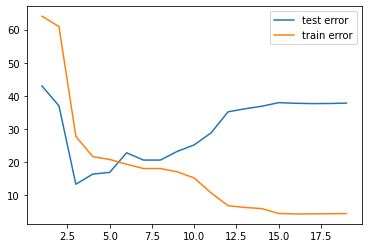

In [12]:
n_samples = 20
# train sample
train_x, train_y = sample(n_samples)
# validation sample
test_x, test_y = sample(n_samples)
max_degree = 20
test_error_vals = []
train_error_vals = []
for degree in range(1, max_degree):
    model = fit_polynomial(train_x, train_y, degree)
    p_y = apply_polynomial(model, train_x)
    train_error_vals.append(pl.norm(train_y - p_y)**2)
    p_y = apply_polynomial(model, test_x)
    test_error_vals.append(pl.norm(test_y - p_y)**2)
pl.plot(range(1, max_degree), test_error_vals, label='test error')
pl.plot(range(1, max_degree), train_error_vals, label='train error')
pl.legend()

Regularization
--------------

Another way to deal with the model complexity is using regularization. A regularizer is a term that penalizes the model complexity and is part of the loss function. the next portion of code shows how the norm of the coefficients of the linear regression model increased when the complexity of the model (polynomial degree) increases.

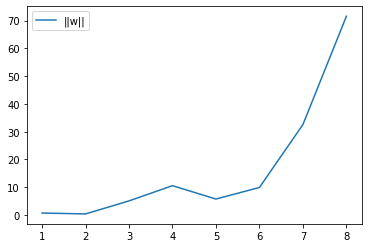

In [14]:
n_samples = 20
train_x, train_y = sample(n_samples)
max_degree = 9
w_norm = []
for degree in range(1, max_degree):
    model = fit_polynomial(train_x, train_y, degree)
    w_norm.append(pl.norm(model.coef_))
pl.plot(range(1, max_degree), w_norm, label='||w||')
pl.legend()

The above result suggests that we can control the complexity by penalizing the norm of the model's weights, $||w||$. This idea is implemented by the *Ridge Regression* method.

### Ridge regression ###

Ridge regression finds a regression model by minimizing the following loss function:

$$ \min_{W}\left\Vert WX-Y\right\Vert ^{2}+\alpha\left\Vert W\right\Vert ^{2} $$

where $X$ and $Y$ are the input matrix and the output vector respectively. The parameter $\alpha$ controls the amount of regularization. You can find more information in the documentation of [scikit-learn ridge regresion implementation](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression). 


#### Exercise ####

Repeat the cross validation experiment using ridge regression. Use a fixed polynomial degree (e.g. 10) and vary the $\alpha$ parameter.

___________________

<h2 id="biblio"> References </h2>

* [Alpaydin10] Alpaydin, E. 2010 [Introduction to Machine Learning][alp10], 2Ed. The MIT Press.

[alp10]: http://www.cmpe.boun.edu.tr/~ethem/i2ml2e/
